# Lab | Text Generation from Shakespeare's Sonnet

This notebook explores the fascinating domain of text generation using a deep learning model trained on Shakespeare's sonnets.

The objective is to create a neural network capable of generating text sequences that mimic the style and language of Shakespeare.

By utilizing a Recurrent Neural Network (RNN) with Long Short-Term Memory (LSTM) layers, this project aims to demonstrate how a model can learn and replicate the complex patterns of early modern English.

The dataset used consists of Shakespeare's sonnets, which are preprocessed and tokenized to serve as input for the model.

Throughout this notebook, you will see the steps taken to prepare the data, build and train the model, and evaluate its performance in generating text.

This lab provides a hands-on approach to understanding the intricacies of natural language processing (NLP) and the potential of machine learning in creative text generation.

Let's import necessary libraries

In [1]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku
import numpy as np

Let's get the data!

In [2]:
import requests
url = 'https://raw.githubusercontent.com/martin-gorner/tensorflow-rnn-shakespeare/master/shakespeare/sonnets.txt'
resp = requests.get(url)
with open('sonnets.txt', 'wb') as f:
    f.write(resp.content)

data = open('sonnets.txt').read()

corpus = data.lower().split("\n")

Step 1: Initialise a tokenizer and fit it on the corpus variable using .fit_on_texts

In [3]:

tokenizer = Tokenizer()


tokenizer.fit_on_texts(corpus)

Step 2: Calculate the Vocabulary Size

Let's figure out how many unique words are in your corpus. This will be the size of your vocabulary.

Calculate the length of tokenizer.word_index, add 1 to it and store it in a variable called total_words.

In [4]:

total_words = len(tokenizer.word_index) + 1  # Add 1 for padding/indexing purposes


print(f"Total unique words in the corpus: {total_words}")


Total unique words in the corpus: 3375


Create an empty list called input_sequences.

For each sentence in your corpus, convert the text into a sequence of integers using the tokenizer.
Then, generate n-gram sequences from these tokens.

Store the result in the list input_sequences.

In [5]:

input_sequences = []

# Loop through each line in the corpus
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]  # Convert text to sequence of integers

    # Generate n-gram sequences
    for i in range(1, len(token_list) + 1):
        n_gram_sequence = token_list[:i]
        input_sequences.append(n_gram_sequence)

# Print a few examples
print("Sample input sequences:", input_sequences[:5])

Sample input sequences: [[878], [3], [3, 2], [3, 2, 313], [3, 2, 313, 1375]]


Calculate the length of the longest sequence in input_sequences. Assign the result to a variable called max_sequence_len.

Now pad the sequences using pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre').
Convert it to a numpy array and assign the result back to our variable called input_sequences.

In [6]:
# Calculate the length of the longest sequence
max_sequence_len = max(len(seq) for seq in input_sequences)

# Pad sequences to ensure uniform length
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')

# Convert to a NumPy array
input_sequences = np.array(input_sequences)

# Print shape to confirm
print(f"Max sequence length: {max_sequence_len}")
print(f"Shape of input_sequences: {input_sequences.shape}")


Max sequence length: 11
Shape of input_sequences: (17805, 11)


Prepare Predictors and Labels

Split the sequences into two parts:

- Predictors: All elements from input_sequences except the last one.
- Labels: The last element of each sequence in input_sequences.

In [7]:
# Split into predictors (X) and labels (y)
X = input_sequences[:, :-1]  # All elements except the last one
y = input_sequences[:, -1]   # The last element as the label

# Print shapes to verify
print(f"Shape of X (predictors): {X.shape}")
print(f"Shape of y (labels): {y.shape}")


Shape of X (predictors): (17805, 10)
Shape of y (labels): (17805,)


One-Hot Encode the Labels :

Convert the labels (which are integers) into one-hot encoded vectors.

Ensure the length of these vectors matches the total number of unique words in your vocabulary.

Use ku.to_categorical() on labels with num_classes = total_words

Assign the result back to our variable labels.

In [8]:
from tensorflow.keras.utils import to_categorical

# Convert labels (y) into one-hot encoded vectors
y = to_categorical(y, num_classes=total_words)

print(f"Shape of y (one-hot encoded labels): {y.shape}")

Shape of y (one-hot encoded labels): (17805, 3375)


# Initialize the Model

Start by creating a Sequential model.

Add Layers to the Model:

Embedding Layer: The first layer is an embedding layer. It converts word indices into dense vectors of fixed size (100 in this case). Set the input length to the maximum sequence length minus one, which corresponds to the number of previous words the model will consider when predicting the next word.

Bidirectional LSTM Layer: Add a Bidirectional LSTM layer with 150 units. This layer allows the model to learn context from both directions (past and future) in the sequence. return_sequences=True

Dropout Layer: Add a dropout layer with a rate of 0.2 to prevent overfitting by randomly setting 20% of the input units to 0 during training.

LSTM Layer: Add a second LSTM layer with 100 units. This layer processes the sequence and passes its output to the next layer.

Dense Layer (Intermediate): Add a dense layer with half the total number of words as units, using ReLU activation. A regularization term (L2) is added to prevent overfitting.

Dense Layer (Output): The final dense layer has as many units as there are words in the vocabulary, with a softmax activation function to output a probability distribution over all words.

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.regularizers import l2


model = Sequential([
    Embedding(input_dim=total_words, output_dim=100, input_length=10),
    Bidirectional(LSTM(150, return_sequences=True)),
    Dropout(0.4),
    LSTM(100),
    Dense(total_words // 2, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(total_words, activation='softmax')
])

model.build(input_shape=(None, 10))

# Compile the Model:

Compile the model using categorical crossentropy as the loss function, the Adam optimizer for efficient training, and accuracy as the metric to evaluate during training.

In [15]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.0005)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


# Print Model Summary:

Use model.summary() to print a summary of the model, which shows the layers, their output shapes, and the number of parameters.

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 10, 100)             │         337,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 10, 300)             │         301,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10, 300)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 75)                  │         112,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1687)                │         128,212 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3375)                │       5,697,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,576,712 (25.09 MB)

 Trainable params: 6,576,712 (25.09 MB)

 Non-trainable params: 0 (0.00 B)

# Now train the model for 50 epochs and assign it to a variable called history.

Training the model with 50 epochs should get you around 40% accuracy.

You can train the model for as many epochs as you like depending on the time and computing constraints you are facing. Ideally train it for a larger amount of epochs than 50.

That way you will get better text generation at the end.

However, dont waste your time.

In [18]:
history = model.fit(X, y, epochs=200, batch_size=128, validation_split=0.1)

Epoch 1/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.2018 - loss: 4.0385 - val_accuracy: 0.0455 - val_loss: 10.5939
Epoch 2/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.2099 - loss: 4.0041 - val_accuracy: 0.0460 - val_loss: 10.5776
Epoch 3/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.2099 - loss: 3.9759 - val_accuracy: 0.0421 - val_loss: 10.7430
Epoch 4/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.2136 - loss: 3.9190 - val_accuracy: 0.0415 - val_loss: 10.7936
Epoch 5/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.2209 - loss: 3.9288 - val_accuracy: 0.0455 - val_loss: 10.8792
Epoch 6/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.2301 - loss: 3.8623 - val_accuracy: 0.0421 - val_loss: 10.9967
Epoch 7/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.2328 - loss: 3.8503 - val_accuracy: 0.0404 - val_loss: 11.1036
Epoch 8/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.2446 - loss: 3.

71% accuracy

# Use plt from matplotlib to plot the training accuracy over epochs and the loss over epochs

First you will have to get the accuracy and loss data over epochs, you can do this by using methods on your model.

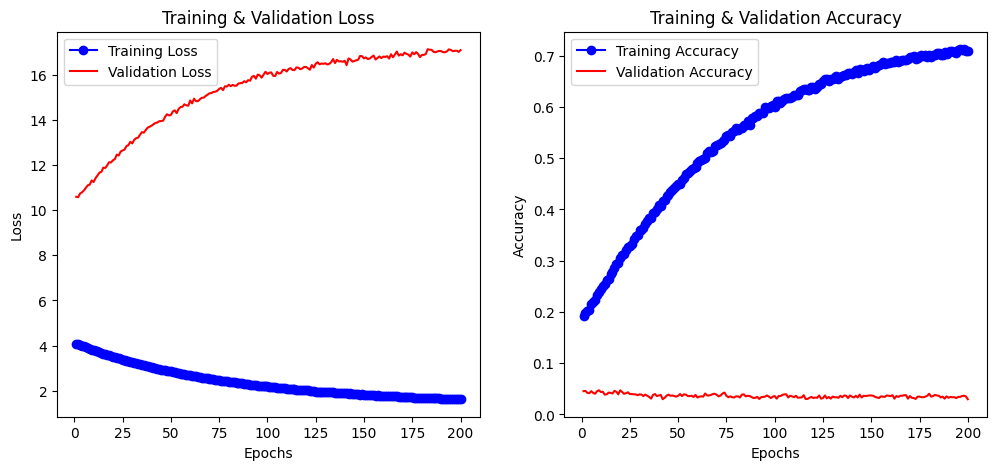

In [19]:
import matplotlib.pyplot as plt

# Extract loss and accuracy from history
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

epochs = range(1, len(loss) + 1)

# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Generate text with the model based on a seed text

Now you will create two variables :

- seed_text = 'Write the text you want the model to use as a starting point to generate the next words'
- next_words = number_of_words_you_want_the_model_to_generate

Please change number_of_words_you_want_the_model_to_generate by an actual integer.

In [23]:
def generate_text(model, tokenizer, seed_text, next_words, max_sequence_len):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]  # Convert text to numbers
        token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre')  # Pad sequence
        predicted = np.argmax(model.predict(token_list, verbose=0), axis=-1)  # Predict next word
        output_word = ""

        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break

        if output_word == "":  # If no word is found, stop generating
            break

        seed_text += " " + output_word

    return seed_text  # <- Ensure the function returns the generated text


Now create a loop that runs based on the next_words variable and generates new text based on your seed_text input string. Print the full text with the generated text at the end.

This time you dont get detailed instructions.

Have fun!

In [24]:
# Try different seed texts
seed_texts = ["Love is a", "The night was", "My heart longs"]
next_words = 10  # Number of words to generate
max_sequence_len = 10  # Must match your model's input shape

# Generate text for each seed
for seed_text in seed_texts:
    generated_text = generate_text(model, tokenizer, seed_text, next_words, max_sequence_len)
    print(f"Seed: '{seed_text}' -> Generated Text: {generated_text}")


Seed: 'Love is a' -> Generated Text: Love is a woman where thou shouldst depart sit flow you idle due
Seed: 'The night was' -> Generated Text: The night was what the very part translate free me lie hid mine
Seed: 'My heart longs' -> Generated Text: My heart longs mine eye the freedom of gentle days gain days live


Experiment with at least 3 different seed_text strings and see what happens!

In [25]:
# Try different seed texts
seed_texts = ["A tower of", "I woke up to", "I swam in the river of"]
next_words = 10  # Number of words to generate
max_sequence_len = 10  # Must match your model's input shape

# Generate text for each seed
for seed_text in seed_texts:
    generated_text = generate_text(model, tokenizer, seed_text, next_words, max_sequence_len)
    print(f"Seed: '{seed_text}' -> Generated Text: {generated_text}")


Seed: 'A tower of' -> Generated Text: A tower of self love back of their glory back barren tell go
Seed: 'I woke up to' -> Generated Text: I woke up to whom my bones with night things deem'd defaced brought to
Seed: 'I swam in the river of' -> Generated Text: I swam in the river of objects should not better heart ' do others hence true
